In [1]:
from skimage import io,filters, morphology, measure, draw,exposure
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import trackpy as tp
import pandas as pd
from scipy.stats import median_abs_deviation
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
from skimage.filters import threshold_otsu, threshold_multiotsu
import seaborn as sns
from tqdm import tqdm

In [2]:
PATH = "</PATH/TO/DIR/>WAVE/Linear_vs_planar/lamellipodia/"

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
def f_x(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

In [5]:
def kde_estimation(data,bins,bandwidth):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(np.array(data)[:, np.newaxis])
    X_plot = np.linspace(np.min(data), np.max(data), bins)[:, np.newaxis]
    log_dens = kde.score_samples(X_plot)
    return log_dens,X_plot

In [6]:
def seg_cells(image, threshold, sigma,min_size, max_size, plot = True):
    """
    Segment out regions with a given fluorescence threshold in a cell
 
    Parameters
    ----------
    image : 2D array
        Raw tif image (single frame).
    threshold: float
        threshold used for segmentation
    sigma: float
        Standard deviation for Gaussian kernel.The larger the value, the smoothier the gaussian fitting.
    min_size: float
        minimum size of the segmented region
    max_size: float
        maximum size of the segmented region
    plot: bool
        whether or not plot the segmentation image
    
    Returns
    -------
    region_properties: list of RegionProperties
        Each item describes one labeled region with the corresponding attributes. 
    label_mask_clean:2D array 
        Segmentations based on fluorescent intensities of the image. 
        Each integer corresponds to a unique segmentation and 0 is the background.
        
    """
    smooth = filters.gaussian(image,sigma,preserve_range=True)
    cell_mask = smooth > threshold
    label_mask = measure.label(cell_mask)
    region_properties = measure.regionprops(label_mask)  
    label_mask_clean = label_mask.copy()
    for r in region_properties:
        if r.area <= min_size or r.area >= max_size:
            label_mask_clean[label_mask_clean == r.label] = 0
    if plot:
        plt.figure(figsize = (10,10))
        plt.imshow(image)
        plt.contour(label_mask_clean,colors = 'red',linewidths = 0.7)

    region_properties = measure.regionprops(label_mask_clean,intensity_image=image)
    return region_properties,label_mask_clean

In [7]:
def normalize_by_cell(result,parax,paray):
    """
    Normalized parax and paray by each cell.
    
    Parameters
    ----------
    result: DataFrame
        containing the raw lamellipodia quantification info
    parax: string
        Parameter to be plotted on the x axis for normalization
    paray: string 
        Parameter to be plotted on the y axis for normalization
    
    Returns
    -------
    result: DataFrame
        Adding the normalized parameters to the input dataframe
    """
    nor_intens = []
    nor_length = []
    parax_max = result[parax].max()
    paray_max = result[paray].max()
    nor_length.extend((result[parax])/parax_max)
    nor_intens.extend((result[paray])/paray_max)
    result['nor_intensity'] = nor_intens
    result['nor_length'] = nor_length
    return result

In [8]:
def CalMean(result,para,n):
    """
    Calculate the average normalized intensity between groups
    
    Parameters
    ----------
    result: DataFrame
        containing ALL of the lamellipodia quantification info (multiple groups)
    para: string
        parameter on the x axis for plotting
    n: inta
        number of sections for calculating the mean
    
    Returns
    -------
    mean: array
        containing the calculated mean
    std: array
        containing the calculated standard deviation
    xaxis: array
        containing the regrouped xaxis 
    
    """
    region = np.linspace(0,1,n)
    mean = []
    std = []
    xaxis = []
    maximum = result[para].max()
    minimum = result[para].min()
    step = (maximum-minimum)/n
    for p in range(len(region)-1):
        data = result[(result[para] <minimum+step*(p+1)) & (result[para] >=minimum+step*p)]['nor_intensity']
        if data.empty:
            continue
        else:
            mean_intensity = data.mean()
            std_intensity = data.std()
            xaxis.append((minimum+step*(p+0.5)))
            if np.isnan(mean_intensity):
                mean.append(data)
            else:
                mean.append(mean_intensity)
            if np.isnan(std_intensity):
                std.append(0)
            else:
                std.append(std_intensity)
    return mean,std, xaxis

# Quantification of lamellipodia

In [28]:
image = io.imread(PATH +'example_images/DUP_pMW7_fmlp_6.tif')

In [29]:
image.shape

(5, 630, 630)

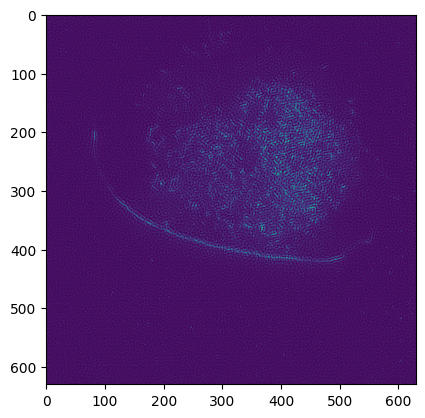

In [30]:
plt.imshow(image[0])

In [31]:
threshold_otsu(image)

8759

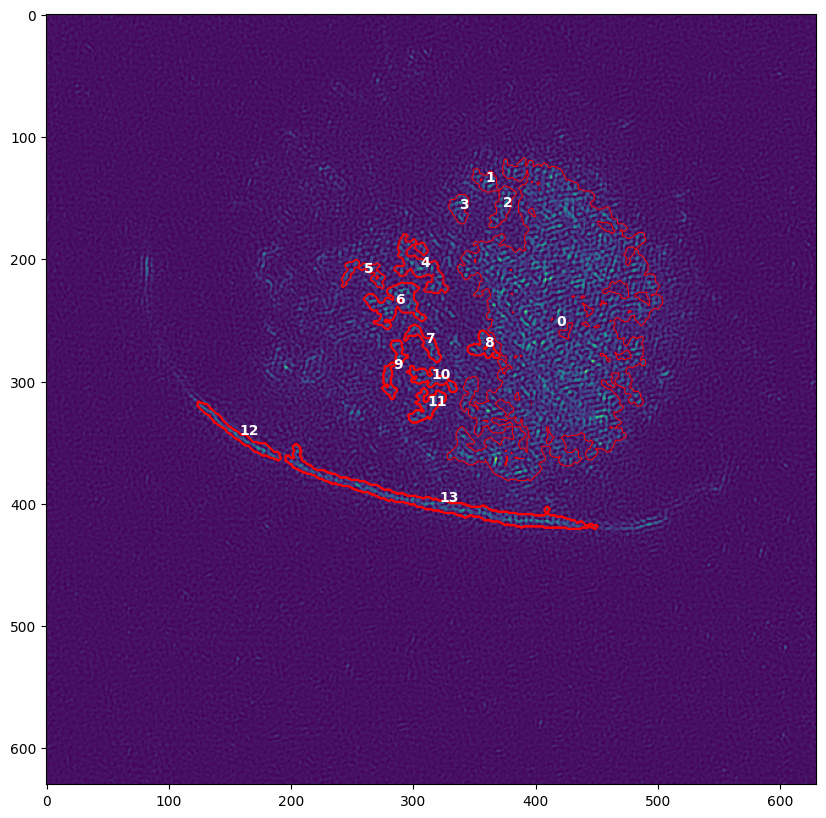

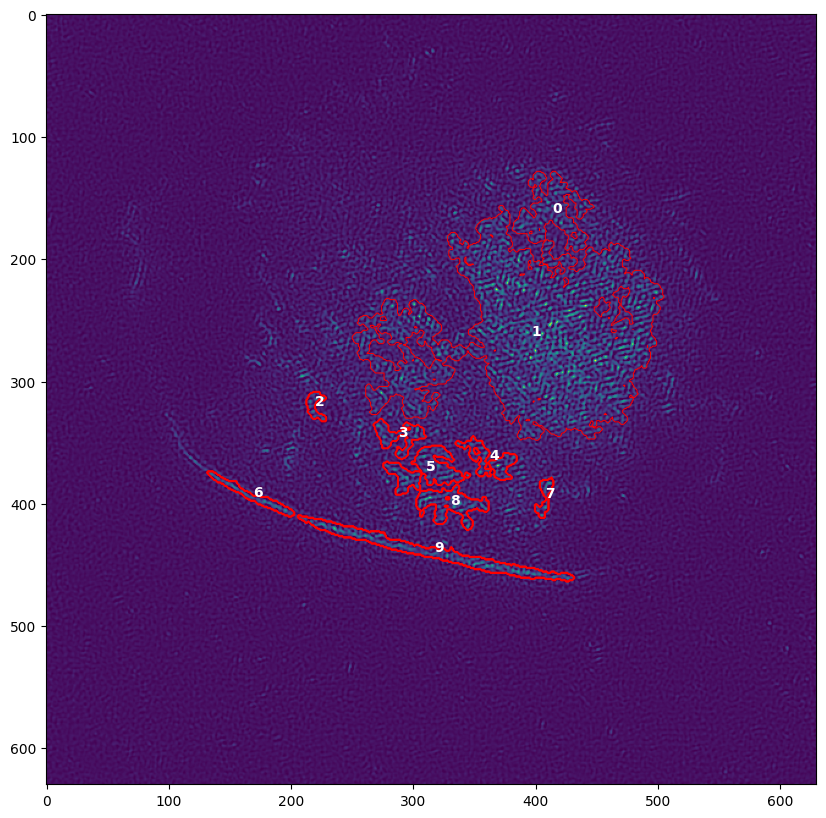

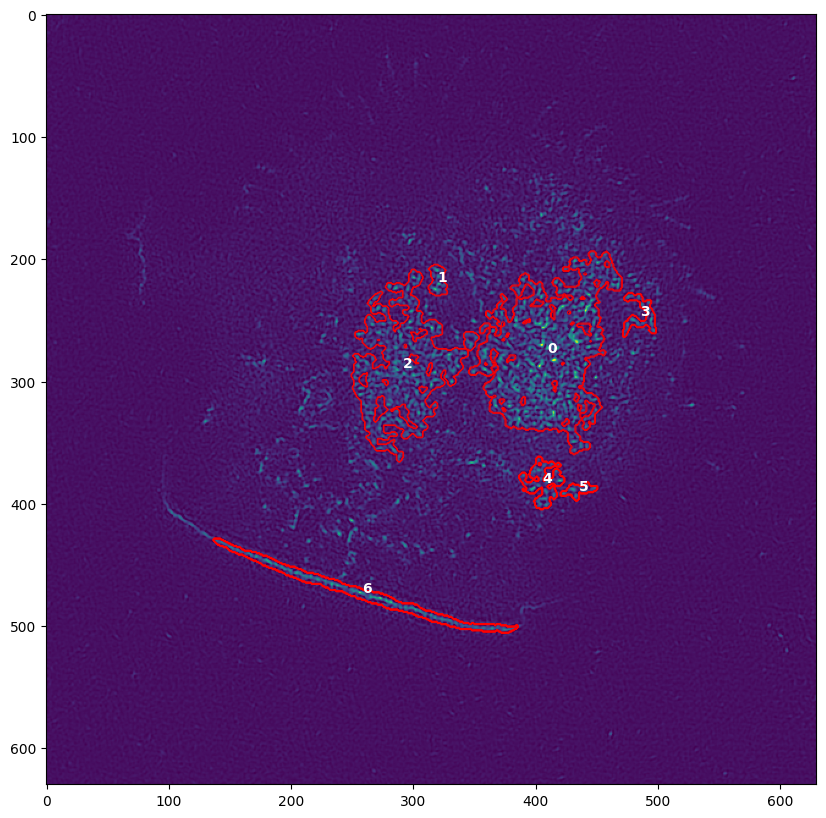

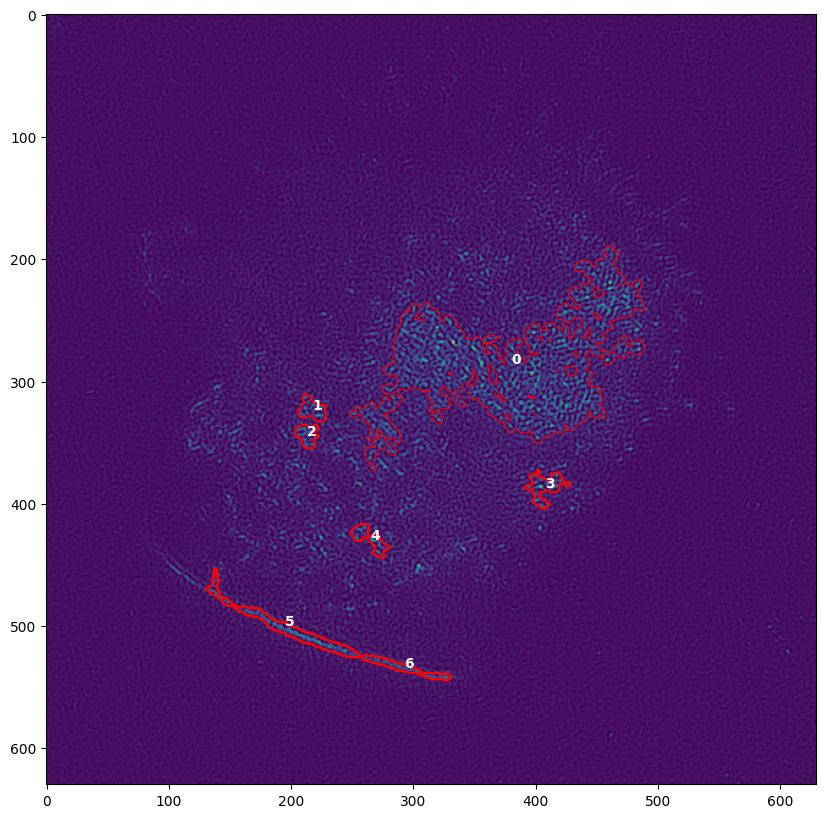

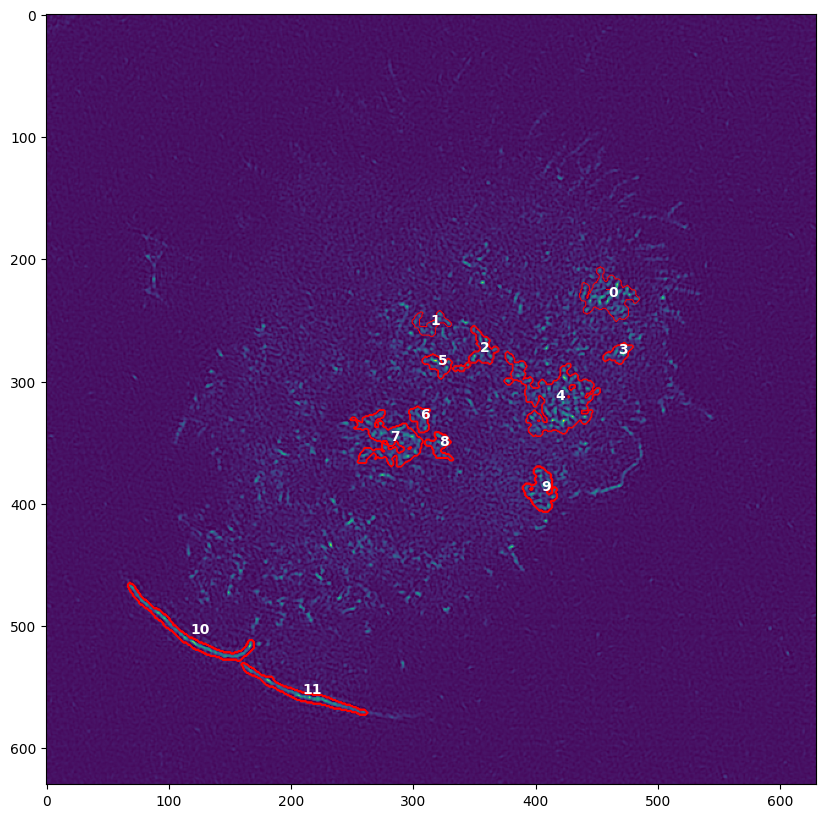

In [35]:
# Segmentation of lamellipodia for quantification
lamelli = pd.DataFrame()
p = 0
threshold = 7200
sigma = 2
# manually picK out the lammelipodia
num =[[12,13],[6,9],[6],[5,6],[10,11]]
for i in range(image.shape[0]):
    prop,label_mask_clean = seg_cells(image[i],threshold,sigma,200,100000,True)
    for r in range(len(prop)): 
        y_center, x_center = prop[r].centroid # note that image coordinates are often given as (y, x) rather than (x, y)
        plt.text(x_center, y_center,r, fontweight = 'bold', color = 'white')

    for n in num[i]:
        lamelli.at[p,'intensity'] = prop[n].intensity_image.sum()
        lamelli.at[p,'area'] = prop[n].area
        lamelli.at[p,'perimeter'] = prop[n].perimeter_crofton
        lamelli.at[p,'label'] = n
        lamelli.at[p,'frame'] = i
        p += 1

In [36]:
lamelli

intensity    area   perimeter  label  frame
0   4853712.0   486.0  172.744161   12.0    0.0
1  22448108.0  2150.0  579.131554   13.0    0.0
2   4307702.0   443.0  166.460976    6.0    1.0
3  19460523.0  1822.0  485.262108    9.0    1.0
4  20279456.0  1760.0  536.861578    6.0    2.0
5   9846850.0   950.0  317.388209    5.0    3.0
6   3555068.0   353.0  157.361520    6.0    3.0
7   8788549.0   737.0  265.867676   10.0    4.0
8   7086308.0   602.0  230.508411   11.0    4.0

In [37]:
normalize_by_cell(lamelli,"perimeter","intensity")

intensity    area   perimeter  label  frame  nor_intensity  nor_length
0   4853712.0   486.0  172.744161   12.0    0.0       0.216219    0.298281
1  22448108.0  2150.0  579.131554   13.0    0.0       1.000000    1.000000
2   4307702.0   443.0  166.460976    6.0    1.0       0.191896    0.287432
3  19460523.0  1822.0  485.262108    9.0    1.0       0.866912    0.837913
4  20279456.0  1760.0  536.861578    6.0    2.0       0.903393    0.927011
5   9846850.0   950.0  317.388209    5.0    3.0       0.438649    0.548042
6   3555068.0   353.0  157.361520    6.0    3.0       0.158368    0.271720
7   8788549.0   737.0  265.867676   10.0    4.0       0.391505    0.459080
8   7086308.0   602.0  230.508411   11.0    4.0       0.315675    0.398024

### 

# Generate plots

In [38]:
total1 = pd.read_csv(PATH + 'csv_data/lamel_g1.csv',index_col=0)
total2 = pd.read_csv(PATH + 'csv_data/lamel_g2.csv',index_col=0)
total3 = pd.read_csv(PATH + 'csv_data/lamel_g3.csv',index_col=0)

In [39]:
total = total1
total = total.append(total2)
total = total.append(total3)

In [40]:
mean_lamel,std_lamel,length_lamel = CalMean(total,'nor_length',25)

In [41]:
popt, pcov = curve_fit(f_x,total['nor_length'],total['nor_intensity']) # your data x, y to fit

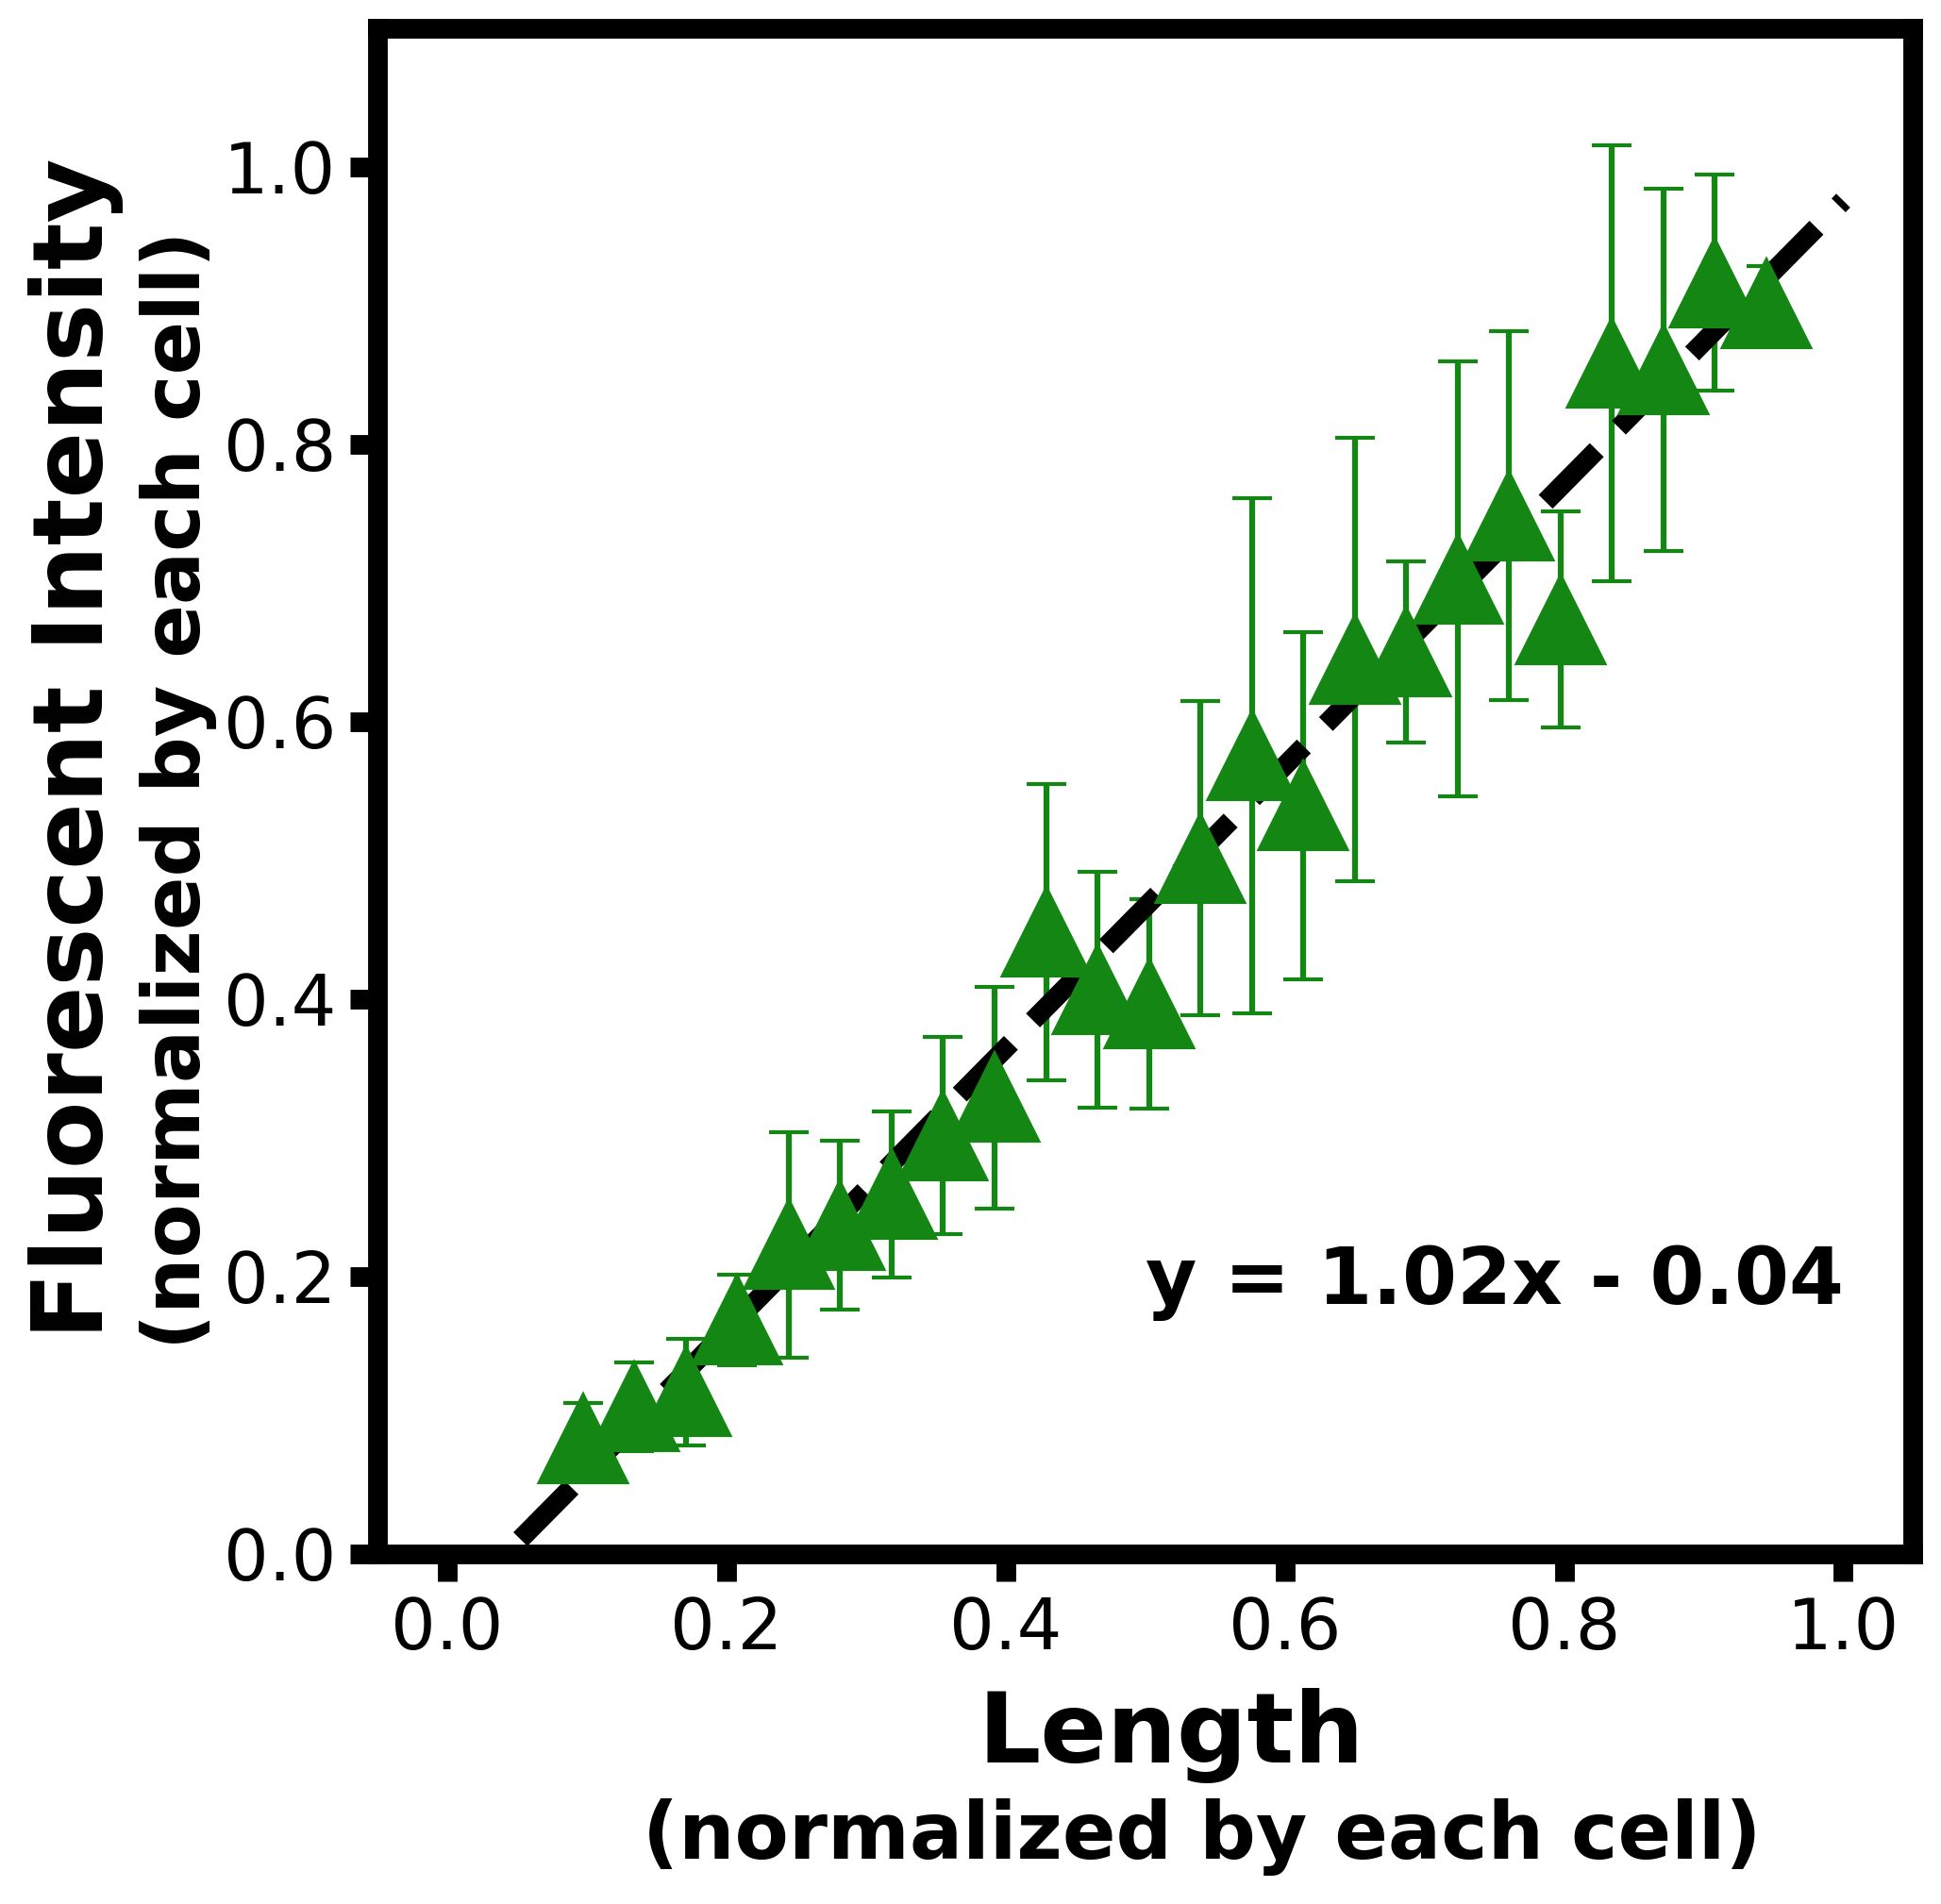

In [42]:
_,ax = plt.subplots(figsize = (7,7),dpi = 300)
plt.errorbar(length_lamel, mean_lamel, std_lamel, linestyle='None',capsize = 5, marker='^',markersize = 22,color = '#138613')
x = np.linspace(0,1,20)
plt.plot(x,f_x(x,popt[0],popt[1]),linestyle = 'dashed',color = 'black',lw = 5)
plt.text(-0.3,0.17,'Fluorescent Intensity',size= 25,rotation = 'vertical',fontweight = 'bold')
plt.text(-0.22,0.16,'(normalized by each cell)',size= 20,rotation = 'vertical',fontweight = 'bold')
plt.text(0.38,-0.15,'Length',size= 25,fontweight = 'bold')
plt.text(0.14,-0.22,'(normalized by each cell)',size= 20,fontweight = 'bold')
plt.yticks(size = 12)
plt.xticks(size = 12)
plt.text(0.5,0.18,'y = ' + "{:.2f}x - {:.2f}".format(popt[0],-popt[1]),size = 20,fontweight = 'bold')
# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(5)

# increase tick width
ax.tick_params(width=5,size = 7)
plt.yticks(size = 18)
plt.xticks(size = 18)
plt.ylim(0,1.1)
plt.savefig(PATH + 'Fig2D_lamellipodia.png',bbox_inches = 'tight',dpi = 300)